In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil

%matplotlib inline
plt.rcParams.update({'font.size': 20})

root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'

In [2]:
def print_mem():
    memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
    print('Current memory usage: {:.2f}GB'.format(memory_usage))
print_mem()

Current memory usage: 0.62GB


In [3]:
def get_r2(true, prediction):
    u = np.sum((prediction-true)**2)
    v = np.sum((true-np.mean(true))**2)
    return 1 - u / v

In [4]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

In [5]:
directory = os.path.join(root_directory,'fly_5','func_0')
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
clustering_dir = os.path.join(directory, 'super_voxels')
brain = bbb.load_numpy_brain(brain_path)*1 # this *1 is currently important for some fucking reason
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))
print_mem()


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 45.49 ms
brain shape is x,y,z,t (77, 128, 49, 4731)
Current memory usage: 9.77GB


In [6]:
t0 = time.time()
one_slice = brain[:,:,20,:].reshape(-1, brain.shape[-1])
print(time.time()-t0)

0.6594576835632324


In [7]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac_raw = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 71.06 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.09 sec


In [8]:
resolution = 100 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = bbb.smooth_and_interp_fictrac(fictrac_raw,
                                                   fps,
                                                   resolution,
                                                   expt_len,
                                                   behavior,
                                                   timestamps=timestamps,
                                                   smoothing=51)
    fictrac[short] = fictrac[short]/np.std(fictrac[short])
xnew = np.arange(0,expt_len,resolution)

In [9]:
for behavior in ['Y', 'Z']:
    fictrac_std = np.std(fictrac[behavior])
    fictrac[behavior] = np.divide(fictrac[behavior],fictrac_std)

### Run clustering - should load from memory

In [81]:
n_clusters = 500
model = AgglomerativeClustering(n_clusters=n_clusters, memory=clustering_dir, linkage='ward')
model = model.fit(one_slice)

### Get avg of each super voxel

In [61]:
signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    mean_signal = np.mean(one_slice[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
    
signals=np.asarray(signals)

In [62]:
signals.shape

(500, 4731)

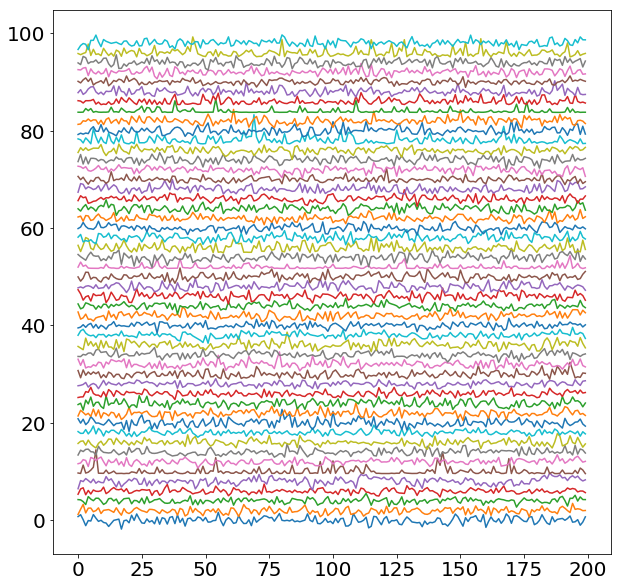

In [13]:
### quick plot
plt.figure(figsize=(10,10))
for i,cluster in enumerate(np.random.randint(0,2000,50)):
    plt.plot(signals[cluster,2000:2200]+i*2);

In [229]:
t0 = time.time()
one_slice_eroded = brain[:,:,20,:].reshape(-1, brain.shape[-1])
print(time.time()-t0)

0.677807092666626


In [10]:
from sklearn.linear_model import RidgeCV
from mpl_toolkits.axes_grid1 import ImageGrid

In [11]:
from sklearn.feature_extraction.image import grid_to_graph
connectivity = grid_to_graph(77,128)

In [282]:
# LOOP
Y_glm = fictrac['Y']
#n_clusters = [9856,9000,8000,7000,6000,5000,4000,3000,2000,1500,1000,750,500,100,10,1]
#n_clusters = [77*128,5000,2000,1500,1000,750,500,100,1]
n_clusters = [8938]
#n_clusters = [1,1000,2000,4000]

#scores = {}
#maps = {}
#alphas = {}

for cluster in n_clusters[::-1]:
    t0 = time.time()
    print('working on cluster {}'.format(cluster))
    model = AgglomerativeClustering(n_clusters=cluster,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    model = model.fit(one_slice_eroded)

    signals = []
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        mean_signal = np.mean(one_slice_eroded[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    X_glm=np.asarray(signals).T

    modelglm = RidgeCV(alphas=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
    modelglm.fit(X_glm, Y_glm)
    
    colored_by_betas = np.zeros(77*128)
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        colored_by_betas[cluster_indicies] = modelglm.coef_[cluster_num]
    colored_by_betas = colored_by_betas.reshape(77,128)
    
    maps[cluster] = colored_by_betas
    scores[cluster] = modelglm.score(X_glm, Y_glm)
    alphas[cluster] = modelglm.alpha_
    
    print('duration {:.0f}s'.format(time.time()-t0))

working on cluster 8938
duration 27s


In [297]:
from sklearn.linear_model import Ridge

In [298]:
# LOOP
Y_glm = fictrac['Y']
#n_clusters = [9856,9000,8000,7000,6000,5000,4000,3000,2000,1500,1000,750,500,100,10,1]
#n_clusters = [77*128,5000,2000,1500,1000,750,500,100,1]
n_clusters = [8938]
#n_clusters = [1,1000,2000,4000]

#scores = {}
#maps = {}
#alphas = {}


cluster = 2000
t0 = time.time()
print('working on cluster {}'.format(cluster))
model = AgglomerativeClustering(n_clusters=cluster,
                                memory=clustering_dir,
                                linkage='ward',
                                connectivity=connectivity)
model = model.fit(one_slice_eroded)

signals = []
for cluster_num in range(cluster):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    mean_signal = np.mean(one_slice_eroded[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
X_glm=np.asarray(signals).T


    

working on cluster 2000


In [302]:
X_glm.shape

(4731, 2000)

In [303]:
Y_glm.shape

(4731,)

In [304]:
from sklearn.model_selection import KFold

In [314]:
for train_index, test_index in kf.split(X_glm):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_glm[train_index], X_glm[test_index]
    y_train, y_test = Y_glm[train_index], Y_glm[test_index]

1
1
1
1
1


In [15]:
#n_clusters = [3000,2000]
n_clusters = [9856,9000,8000,7000,6000,5000,4000,3000,2000,1500,1000,750,500,100,10,1]

cluster_signals = {}

for cluster in n_clusters:
    print('working on cluster {}'.format(cluster))
    model = AgglomerativeClustering(n_clusters=cluster,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    model = model.fit(one_slice)

    signals = []
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        mean_signal = np.mean(one_slice[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    X_glm=np.asarray(signals).T
    
    cluster_signals[cluster] = X_glm

working on cluster 9856
working on cluster 9000
working on cluster 8000
working on cluster 7000
working on cluster 6000
working on cluster 5000
working on cluster 4000
working on cluster 3000
working on cluster 2000
working on cluster 1500
working on cluster 1000
working on cluster 750
working on cluster 500
working on cluster 100
working on cluster 10
working on cluster 1


In [331]:
cluster_signals[2000].shape

(4731, 2000)

In [437]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(X_glm)
print(kf)

KFold(n_splits=5, random_state=0, shuffle=True)


4731

In [438]:
alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]

scores = {}

for cluster in n_clusters:
    print(cluster)
    t0=time.time()
    
    X_glm = cluster_signals[cluster]
    scores[cluster] = {}
    
    for alpha in alphas:
        print(alpha)

        scores[cluster][alpha] = {}
        train_scores = []
        test_scores = []
        
        for train_index, test_index in kf.split(X_glm):

            X_train, X_test = X_glm[train_index], X_glm[test_index]
            Y_train, Y_test = Y_glm[train_index], Y_glm[test_index]

            modelglm = Ridge(alpha=alpha)
            modelglm.fit(X_train, Y_train)
            train_scores.append(modelglm.score(X_train, Y_train))
            test_scores.append(modelglm.score(X_test, Y_test))

        scores[cluster][alpha]['train'] = np.mean(train_scores)
        scores[cluster][alpha]['test'] = np.mean(test_scores)
        
    print('duration {:.0f}s'.format(time.time()-t0))

9856
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 117s
9000
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 94s
8000
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 103s
7000
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 128s
6000
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 137s
5000
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 114s
4000
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 102s
3000
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 40s
2000
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
1

In [13]:
X_glm.shape[0]

NameError: name 'X_glm' is not defined

In [464]:
n_clusters

In [12]:
# same as above, except sanity check with my own CV indexing

alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]

n_folds = 5

scores = {}

for cluster in n_clusters:
    print(cluster)
    t0=time.time()
    
    X_glm = cluster_signals[cluster]
    scores[cluster] = {}
    
    for alpha in alphas:
        print(alpha)

        scores[cluster][alpha] = {}
        train_scores = []
        test_scores = []
        
        for fold in range(n_folds):
            indicies = list(range(X_glm.shape[0]))
            random.shuffle(indicies)
            split = int(X_glm.shape[0]/n_folds)
            train_indicies = indicies[:split]
            test_indicies = indicies[split:]

            X_train, X_test = X_glm[train_indicies], X_glm[test_indicies]
            Y_train, Y_test = Y_glm[train_indicies], Y_glm[test_indicies]

            modelglm = Ridge(alpha=alpha)
            modelglm.fit(X_train, Y_train)
            train_scores.append(modelglm.score(X_train, Y_train))
            test_scores.append(modelglm.score(X_test, Y_test))

        scores[cluster][alpha]['train'] = np.mean(train_scores)
        scores[cluster][alpha]['test'] = np.mean(test_scores)
        
    print('duration {:.0f}s'.format(time.time()-t0))

NameError: name 'n_clusters' is not defined

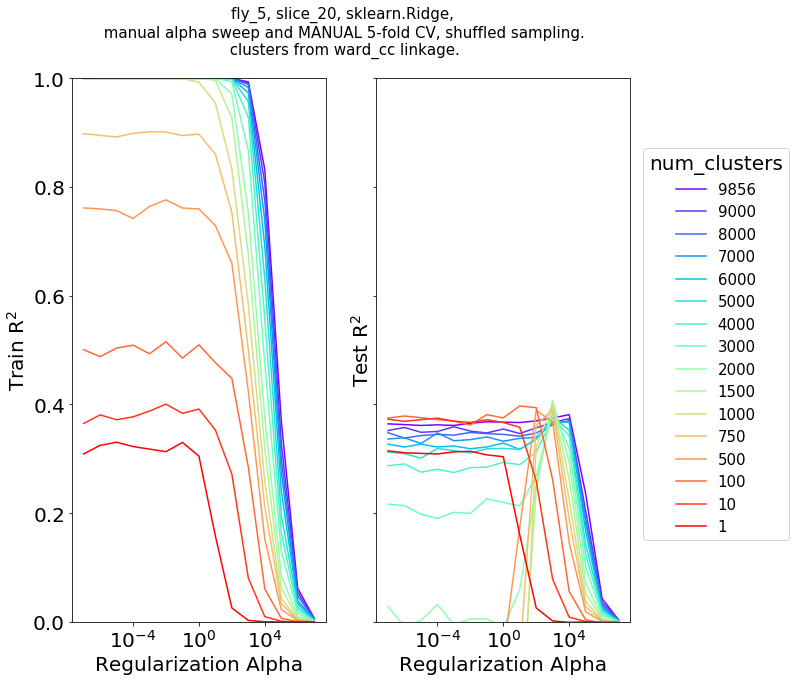

In [471]:
fig, axs = plt.subplots(1,2, figsize=(10,10), sharey=True)

colors = plt.cm.rainbow(np.linspace(0,1,len(n_clusters)))
for i,cluster in enumerate(n_clusters):
    axs[0].plot([x for x in alphas], [scores[cluster][x]['train'] for x in alphas],'-',label=cluster,color=colors[i])
    
for i,cluster in enumerate(n_clusters):
    axs[1].plot([x for x in alphas], [scores[cluster][x]['test'] for x in alphas],'-',label=cluster,color=colors[i])

axs[0].set_ylabel('Train R$^2$')
axs[1].set_ylabel('Test R$^2$')

for ax in axs:
    ax.set_xscale('log')
    ax.set_ylim(0,1)
    ax.set_xlabel('Regularization Alpha')
    
axs[1].legend(loc=(1.05,.15), title='num_clusters',fontsize=15)
plt.suptitle(x=.5,y=.98,t='fly_5, slice_20, sklearn.Ridge,\n manual alpha sweep and MANUAL 5-fold CV, shuffled sampling.\n clusters from ward_cc linkage.',fontsize=15)


save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

Text(0.5, 1.0, 'odd behavior of sklearn.RidgeCV')

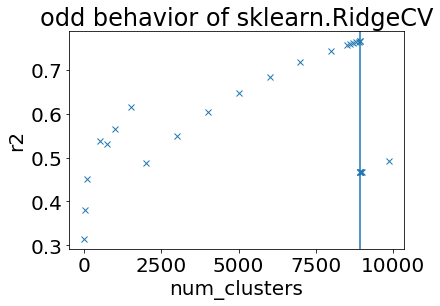

In [295]:
plt.plot([x for x in scores], [scores[x] for x in scores], marker='x', linestyle='None')
#plt.xlim(8900,9000)
plt.axvline(8938)
plt.ylabel('r2')
plt.xlabel('num_clusters')
plt.title('odd behavior of sklearn.RidgeCV')

In [294]:
1e6

1000000.0

Text(0.5, 1.0, 'odd behavior of sklearn.RidgeCV')

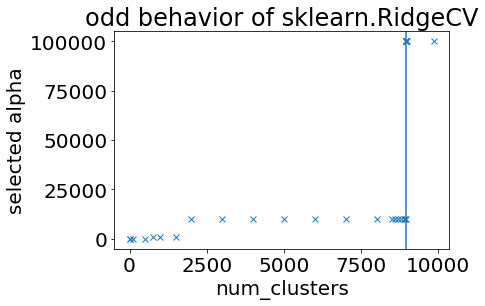

In [296]:
plt.plot([x for x in alphas], [alphas[x] for x in alphas], marker='x', linestyle='None')
#plt.xlim(8900,9000)
plt.axvline(8938)
plt.ylabel('selected alpha')
plt.xlabel('num_clusters')
plt.title('odd behavior of sklearn.RidgeCV')

In [285]:
[x for x in scores]

[1,
 10,
 100,
 500,
 750,
 1000,
 1500,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 9856,
 8500,
 8600,
 8700,
 8800,
 8900,
 8950,
 8925,
 8937,
 8943,
 8940,
 8939,
 8938]

(8900, 9000)

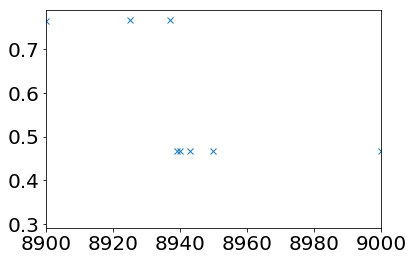

In [281]:
plt.plot([x for x in scores], [scores[x] for x in scores], marker='x', linestyle='None')
plt.xlim(8900,9000)

In [289]:
n_clusters

[8938]

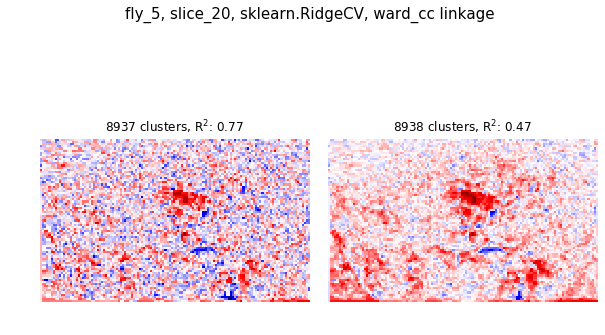

In [290]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.25)
n_clusters = [8937, 8938]
for i,cluster in enumerate(n_clusters):
    grid[i].imshow(maps[cluster], cmap='seismic', vmin=-np.max(maps[cluster]), vmax=np.max(maps[cluster]))
    grid[i].axis('off')
    grid[i].set_title('{} clusters, R$^2$: {:.2f}'.format(cluster, scores[cluster], alphas[cluster]),
                      fontsize=12,
                      x=.5,y=1.1,
                      horizontalalignment='center',
                      verticalalignment='top')
plt.suptitle(x=.5,y=.8,t='fly_5, slice_20, sklearn.RidgeCV, ward_cc linkage',fontsize=15)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [254]:
[x for x in scores]

[1,
 10,
 100,
 500,
 750,
 1000,
 1500,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 9856]

In [177]:
signals = []
for cluster_num in range(1):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    mean_signal = np.mean(one_slice[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
X_glm=np.asarray(signals).T

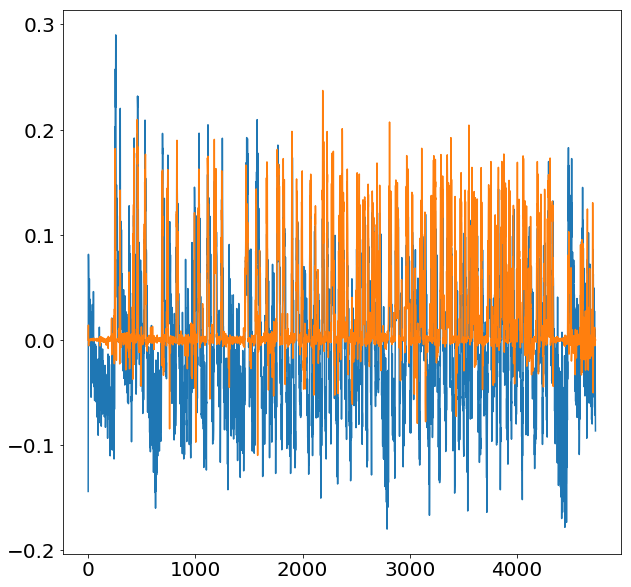

In [184]:
plt.figure(figsize=(10,10))
plt.plot(X_glm)
plt.plot(fictrac['Y']/20)

In [178]:
X_glm.shape

(4731, 1)

In [63]:
Y_glm = fictrac['Y']
X_glm = signals.T

In [92]:
t0=time.time()

modelglm = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
modelglm.fit(X_glm, Y_glm)

print(time.time()-t0)

0.4061403274536133


In [98]:
modelglm.score(X_glm, Y_glm)

0.5395204774338546

In [76]:
model.alpha_

100.0

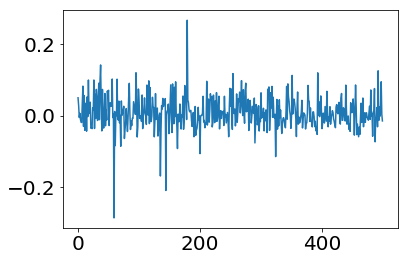

In [77]:
plt.plot(model.coef_)

In [14]:
from sklearn.linear_model import MultiTaskLassoCV

In [16]:
X_glm.shape

(4731, 2000)

In [16]:
glmmodel = MultiTaskLassoCV()

In [17]:
t0=time.time()
glmmodel.fit(X_glm, Y_glm)
print(time.time()-t0)

2441.9425439834595


In [22]:
2475.7943801879883/60

41.2632396697998

In [18]:
prediction = glmmodel.predict(X_glm)
score_y = get_r2(fictrac['Y'], prediction[:,0])
score_z = get_r2(fictrac['Z'], prediction[:,1])
print(score_y, score_z)

0.5203943935562458 0.15379630734861682


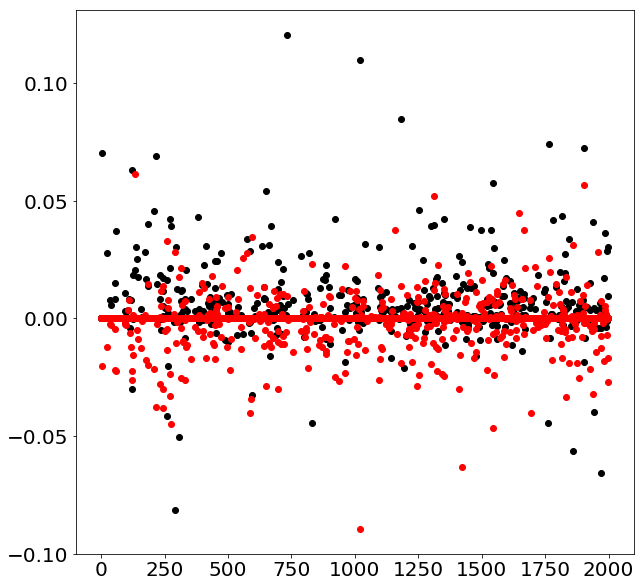

In [19]:
plt.figure(figsize=(10,10))
plt.plot(glmmodel.coef_[0,:],'o',color='k')
plt.plot(glmmodel.coef_[1,:],'o',color='r')

### Plot supervoxels colored by glm weights

In [111]:
### GLM

# Forward
colored_by_betas_Y = np.zeros(n_samples)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    colored_by_betas_Y[cluster_indicies] = glmmodel.coef_[0,cluster_num]
colored_by_betas_Y = colored_by_betas_Y.reshape(77,128)

# Rotation
colored_by_betas_Z = np.zeros(n_samples)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    colored_by_betas_Z[cluster_indicies] = glmmodel.coef_[1,cluster_num]
colored_by_betas_Z = colored_by_betas_Z.reshape(77,128)

In [122]:
### Corr

# Forward
colored_by_corr_Y = np.zeros(n_samples)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    colored_by_corr_Y[cluster_indicies] = pearsonr(signals[cluster_num,:], fictrac['Y'])[0]
colored_by_corr_Y = colored_by_corr_Y.reshape(77,128)

# Rotation
colored_by_corr_Z = np.zeros(n_samples)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    colored_by_corr_Z[cluster_indicies] = pearsonr(signals[cluster_num,:], fictrac['Z'])[0]
colored_by_corr_Z = colored_by_corr_Z.reshape(77,128)

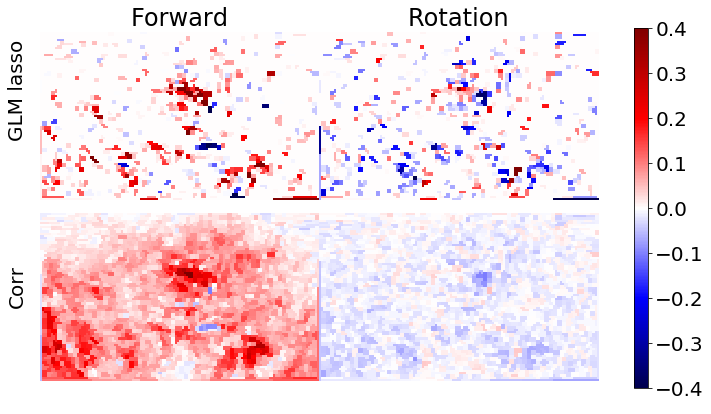

In [257]:
fig=plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(colored_by_betas_Y,vmin=-.05,vmax=.05,cmap='seismic')
plt.title('Forward')
plt.axis('off')
plt.text(-15,10,'GLM lasso',rotation=90)

plt.subplot(2,2,2)
plt.imshow(colored_by_betas_Z,vmin=-.05,vmax=.05,cmap='seismic')
plt.title('Rotation')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(colored_by_corr_Y,vmin=-.4,vmax=.4,cmap='seismic')
plt.axis('off')
plt.text(-15,30,'Corr',rotation=90)

plt.subplot(2,2,4)
plt.imshow(colored_by_corr_Z,vmin=-.4,vmax=.4,cmap='seismic')
plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=-.5)

ax_cbar=fig.add_axes([.95,.25,.02,.5])
#ax_cbar = fig.add_subplot(121)
#plt.colorbar(ax=ax)
#cmap = mpl.cm.cool
#norm = mpl.colors.Normalize(vmin=5, vmax=10)
#fig.colorbar(cm.ScalarMappable(norm=1, cmap='seismic'), cax=ax)

ax_cbar.plot()
sm = plt.cm.ScalarMappable(cmap='seismic', norm=mpl.colors.Normalize(vmin=-.4, vmax=.4))
sm._A = []
plt.colorbar(sm, cax=ax_cbar)

timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [84]:
### GLM

# Forward
colored_by_betas = np.zeros(77*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    colored_by_betas[cluster_indicies] = modelglm.coef_[cluster_num]
colored_by_betas = colored_by_betas.reshape(77,128)

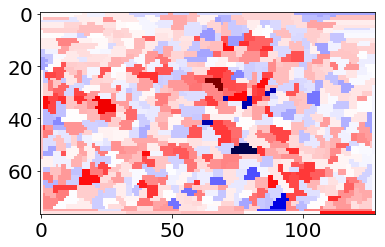

In [86]:
plt.imshow(colored_by_betas,cmap='seismic')